# Binary Hypothesis Testing with Real Data

When dealing with data from different groups, we will generally observe differences. For instance, we may measure the means or medians of the data sets and we will usually find that these summary statistics are different.  At this point, we wish to understand whether the observed difference is "significant": is this difference a property of the underlying groups or is it just caused by random variations in the data?





In [1]:
# This is included here but hidden because a reader of the book can work straight
# through with the same variables, but for users downloading the notebooks, this
# separate Juypter notebook needs to recreate those variables from the CSV file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/main/03-first-data/covid-merged.csv"
)
df.set_index("state", inplace=True)
df["cases_norm"] = df["cases"] / df["population"] * 1000
df["gdp_norm"] = df["gdp"] / df["population"] * 1000;

As we saw in Chapter 2, the number of samples of random phenomena has a significant impact on how accurately we can estimate those phenomena. When it comes to real data, the problem is amplified because we do not know the ground-truth characterization of the random phenomena that is producing the data. 

Let's start by restricting our analysis to a very small subset of our data to see how effects observed with small data may be caused simply by random sampling. By restricting our data, we can show examples of the technique that we will be using, and the examples will be small enough to easily understand.


## Small Data Example Using Covid Rates


Consider the normalized Covid case rates from the first six states, and partition them into two sets using alphabetical order:

In [2]:
a = df.loc[:"Arizona"]
a

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Alabama,7068,4903185,230750.1,59.04,1.441512,47.061267
Alaska,353,731545,54674.7,66.02,0.482540,74.738670
Arizona,7648,7278717,379018.8,89.81,1.050735,52.072199


In [3]:
b = df.loc["Arkansas":"Colorado"]
b

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Arkansas,3281,3017804,132596.4,56.16,1.087214,43.938042
California,50470,39512223,3205000.1,94.95,1.277326,81.114143
Colorado,15207,5758736,400863.4,86.15,2.640684,69.609616


Because the data is so small, histograms do not make sense. Instead, we directly turn to using summary statistics. The means for these data sets are

In [4]:
a["cases_norm"].mean()

0.9915956672540028

In [5]:
b["cases_norm"].mean()

1.6684081069437913

Note that the mean Covid case rate for states in group $b$ is much larger then for states in group $a$. To carry out a statistical test, we usually want to reduce the observed data to a single statistic, called the *test statistic*:

````{card}

DEFINITION
^^^
```{glossary}
test statistic
  A single numerical value that can be used in a statistical test.
```
````

When are comparing two groups and observe different values for some summary statistic of the two groups, then the usual test statistic to use is the difference between the values of the summary statistic. For our example, this is the difference of the means. Usually the terms in the difference are ordered so that the difference will come out to be a positive value. Thus, for the difference of means, the test statistic is

In [6]:
diff = b["cases_norm"].mean() - a["cases_norm"].mean()
diff

0.6768124396897884

Seeing such a large difference, we would like to consider possible hypotheses (possible explanations) for the difference. Some possible hypotheses for the observed difference between groups $a$ and $b$ are:
1. States that come later alphabetically might have higher Covid rates. It seems hard to justify why that would be the case, thought.
2. The states in group $b$ might differ from the states in group $a$ in some significant way. This could be the case, but we might want to consider another possibility first.
3. The differences might just caused by random sampling. That is, the Covid rates all come from the same underlying random phenomena, but because of randomness, some states end up with higher rates in the observed data than others. In the groups $a$ and $b$, it just happened by randomness that $b$ ended up with more higher rates, and $a$ ended up with more lower rates.

In statistics, we want to create hypotheses that can be *tested*, which means that we can assess the likelihood that the hypothesis true or false.  In this case, we use the term *statistical hypothesis*:

````{card}
DEFINITION
^^^
```{glossary}
statistical hypothesis
    an explanation for phenomena observed in a data set that can be formally tested using the data
```
```` 

Hypothesis 3 is a very common type of statistical hypothesis when working with two groups of data that have different values for some summary statistic of interest. This type of hypothesis is called the *null hypothesis*:


````{card}
DEFINITION
^^^
```{glossary}
null hypothesis (for multiple groups)
    the hypothesis that the feature(s) being measured come from the same random phenomena; any observed differences come from issues related to random sampling, such as having sets that are too small to accurately measure the true value of some summary statistic
```
```` 


The concept of the null hypothesis was introduced in *The Design of Experiments* by Sir Ronald A. Fisher, Hafner Press, New York, 1935. It is helpful to introduce mathematical notation to refer to hypotheses. The null hypothesis is usually denoted by $H_0$, which is typically read as "H naught". Intuitively, the zero can be read as implying zero difference between the populations (in the feature being compared).

When there is a null hypothesis, we typically compare it with the hypothesis that the feature being measured comes from random phenomena that differ between the two groups. We call this the *alternative hypothesis* and denote it by $H_a$.

Usually, $H_a$ cannot be tested directly because we do not know ahead of time *how* the underlying phenomena differ. Thus, we will usually conduct tests by assuming the null hypothesis is true. Then, apply an approach similar to falsification in the natural sciences: we try to determine the probability that the observed test statistic value have come from the null hypothesis, and if the result is  has a very low probability of occurring under the null hypothesis, then an alternative hypothesis is likely true. (Note that randomness in the data will usually prevent us from deciding that any hypothesis is absolutely true; i.e., we will only be able to estimate the probabilities of hypotheses.)

````{card}
DEFINITION
^^^
```{glossary}
binary hypothesis test 
    A binary hypothesis test is a statistical test that decides between two competing statistical hypotheses.
```
```` 

We will consider estimating the probability of some observed statistic occurring under the assumption that $H_0$ is true:

```{index} see: NHST ; null hypothesis significance test (NHST)
```
````{card}
DEFINITION
^^^
```{glossary}
null hypothesis significance test (NHST)
    A type of binary hypothesis  test that estimates the probability of observing such a large value of the  statistic under the condition that some null hypothesis, $H_0$, is true.
```
````
There are several methods to test the null hypothesis. Before introducing the technique we will use, we note that statistical methods can generally be put into one of two categories:
1. In *model-based* methods, we assume that (under $H_0$), the summary statistics we use will fit certain statistical models, and we can typically use those models to produce an analytic estimate for the probability of observing such a large difference in the observed summary statistics.
2. In *model-free* methods, we use techniques to estimate the probability of seeing such a large difference without assuming any model for the summary statistics, but instead make other assumptions, such as that samples from the data itself can represent samples from the underlying random phenomena.

It is important to note that either approach will rely on assumptions. In this section and throughout most of this book,  we will primarily use the model-free method because it has several important advantages:
1. It does not require certain size data before the model is accurate.
2. It does not require analytical formulas to be available for every summary statistic that may be considered.
3. It does not rely on mathematical formulas that may seem obscure or that require a significant amount of foundational work in probability to understand.
4. The model-free approach we will use is easier to get started with, especially for engineers who are experienced in programming and simulating phenomena.

The approach we will use is called *resampling*:


````{card}
DEFINITION
^^^
```{glossary}
resampling
    Resampling is a type of statistical simulation in which new samples are repeatedly drawn from the existing data for each of the groups under consideration, and the statistical measures being used are evaluated for each of the new sample groups. 
```
```` 





When using two-group null hypothesis testing via resampling, our assumption is that the data in the two groups come from the same underlying random phenomena. Thus, we can pool the data from the two groups, and then we draw samples from the pooled data to represent samples from the underlying random phenomena. 

We can put all the data into one long NumPy array by horizontally stacking the data. To do this we use NumPy's `hstack` function:



In [7]:
pooled = np.hstack((a["cases_norm"], b["cases_norm"]))
pooled

array([1.441512  , 0.48254038, 1.05073463, 1.08721441, 1.27732626,
       2.64068365])

Since we have numerical data, we leverage the `numpy.random` library to draw samples, which we will import as `npr`:

In [8]:
import numpy.random as npr

Random number generators, such as the one used by `numpy.random`  produce a sequence of pseudo-random numbers, which look random but are actually deterministic if the internal state of the random number generator is known. This internal state can be set using a "seed". To allow readers to obtain the same results as those shown in this book, I set the seed of the random number generator as shown below (where the see value was chosen arbitrarily). However, be aware that if you re-run cells or run cells out of order, you will get different results.

In [9]:
npr.seed(21341)

Now we can randomly draw data from `pooled` using `npr.choice`, which requires a variable to draw from as the first argument and can take a second argument as the number of items to draw (if not given, the default is one).

In [10]:
npr.choice(pooled, 3)

array([1.05073463, 1.05073463, 2.64068365])

Note that the resulting array has a repeated value, even though there are no repeated values in `pooled`. There are two ways to sample from data:
1. **Sampling with replacement:** Items drawn are placed back into the array from which data is being sampled. Any number of items may be drawn.
2. **Sampling without replacement:** Items drawn are removed from the array from which data is being sampled. The maximum number of items that can be drawn is the size of the original array.

`npr.choice` defaults to sampling with replacement, but can use sampling without replacement by passing the keyword argument `replace=False`.

For example, here are two draws of 6 items using each approach:

In [11]:
npr.seed(21398475)
print(npr.choice(pooled, 6))
print(npr.choice(pooled, 6, replace=False))

[1.27732626 0.48254038 1.05073463 1.27732626 1.27732626 0.48254038]
[1.05073463 1.27732626 1.08721441 0.48254038 1.441512   2.64068365]


To perform resampling, we simulate how $a$ and $b$ **could have been created** if they came from the same random phenomena. Thus, we 
create new $\tilde{a}$ and $\tilde{b}$ that contain the same number of samples as $a$ and $b$, respectively, but where the samples are drawn from the pooled data. In this chapter, we use the most popular method, which is drawing the data **with replacement**.  This is commonly called **bootstrap sampling**, and the purpose of bootstrap sampling is to simulate random values of the test statistic under $H_0$. 

When creating the new groups, it is important to use the same sizes as the original groups. The cell below will perform one such random draw of $\tilde{a}$ and $\tilde{b}$, which in Python I call `newa` and `newb`.

Try running the cell below a few times:

In [12]:
alen = len(a)
blen = len(b)
newa = npr.choice(pooled, alen)
newb = npr.choice(pooled, blen)
print("new a:", newa)
print("new b:", newb)

new a: [0.48254038 2.64068365 1.05073463]
new b: [0.48254038 0.48254038 1.05073463]


Our goal is to determine whether the observed value of the test statistic could be attributed just to randomness. We want to use resampling to determine how often we see such a large difference in means under $H_0$. Copy the cell from above and then add the line shown at the end of the cell below to print out the difference in means. Run the cell below a few times to see what can happen:

In [13]:
alen = len(a)
blen = len(b)
newa = npr.choice(pooled, alen)
newb = npr.choice(pooled, blen)
print("new a:", newa)
print("new b:", newb)

print("original diff", diff)
print("new diff", newb.mean() - newa.mean())

new a: [0.48254038 1.441512   1.441512  ]
new b: [2.64068365 2.64068365 1.441512  ]
original diff 0.6768124396897884
new diff 1.119104975459625


One thing to note is that the new difference can be either positive or negative. We previously mentioned that we want to determine "how often we see such a large difference", but this turns out to be ambiguous, because we could use the magnitude (absolute value) of the new difference or we could use the signed new difference. For now, let's use the magnitude, which is called a two-sided test. I will have more to say about one-sided tests vs. two sided tests in {doc}`Chapter 5<../05-binary-hypothesis-testing/intro>`.



Now, we will see how to build a simulation to estimate the probability of seeing such a large difference in sample means under $H_0$. This probability is called the $\mathbf{p}$**-value**. For now, we will say that the difference is statistically significant if the observed $p$-value is smaller than a threshold. In other words, the result is considered to be statistically significant if it is very unlikely to have seen such an extreme difference in summary statistics between the groups under the null hypothesis. 

An important part of statistical testing is to declare what is being tested and what the criterion is for statistical significance **before** performing the statistical tests. Thus, we need to determine the $p$-value threshold **before** running the simulation. For instance, if $H_0$ is true and we see differences as large as we observed in our data 10% of the time, should we consider the observed difference significant? What if it were only 5% of the time? How about only 1% of the time? There is no right answer to that question.
The threshold for rejecting the null hypothesis
will determine the maximum probability that we will allow for making the error of rejecting the null hypothesis when it is actually true. For instance if the threshold is 10%, then if there is no actual difference between the groups for the random phenomena being measured, a difference in summary statistics as large as the one observed could still occur as often as 10% of the time. In many scientific fields, a $p$-value threshold of 5% is used. In this book, I will use a $p$-value threshold of 1%, which can be considered to be more "strict" in the sense that we are less likely to reject the null hypothesis.

Note that if the estimated $p$-value is above the threshold, that does not mean that the null hypothesis is true or that the alternative hypothesis is false. We say that we "fail to reject the null hypothesis". In many such cases, the null hypothesis will actually be false but we just do not have enough data to support rejecting the null hypothesis.

With these details out of the way, we can build our simulation. As in Chapter 2, the simulation is a `for` loop in which each iteration of the for loop represents one random draw. Here, each iteration creates two groups $\tilde{a}$ and $\tilde{b}$ by drawing randomly from the pooled data. For each draw, we calculate the averages, and we use a counter to track how often we observe an absolute difference in means that is large as we observed in the original data.

In [14]:
# These are common to most simulation:
# 1) Set up the number of iterations (draws from the pool)
# 2) Initialize our counter to zero
num_sims = 10_000
count = 0

# Put these outside the loop to save execution time, since they don't change
alen = len(a)
blen = len(b)


for sim in range(num_sims):
    # Bootstrap sampling
    newa = npr.choice(pooled, alen)
    newb = npr.choice(pooled, blen)

    # Calculate the absolute value of the difference of means
    newdiff = abs(newa.mean() - newb.mean())

    # Update the counter if it exceeds the difference from the original groups
    if newdiff >= diff:
        count += 1

print("Prob. of seeing a result this extreme =~", count / num_sims)

Prob. of seeing a result this extreme =~ 0.2038


Run the cell above a few times. The results will vary, but should be close to 0.2. Since this $p$-value is much larger than our threshold of 1% (i.e., 0.01), we **fail to reject the null hypothesis**. The observed difference will occur approximately 20% of the time even if there is no difference in normalized Covid rates among these states.

## Testing the Observed Differences in Covid Rates

Now let's apply bootstrap resampling to test the previous observed differences in covid rates based on GDP per population:

In [15]:
m_gdp = df["gdp_norm"].median()
m_gdp
higher_gdp = df[df["gdp_norm"] > m_gdp]
lower_gdp = df[df["gdp_norm"] <= m_gdp]
hgdp_mu = higher_gdp["cases_norm"].mean()
lgdp_mu = lower_gdp["cases_norm"].mean()

As a reminder, we previously found the mean Covid rates per population for higher GDP and lower GDP states to be:

In [16]:
hgdp_mu, lgdp_mu

(3.511232264232122, 1.9258062634390536)

The first step of our binary hypothesis test is to calculate the difference in means:

In [17]:
diff_gdp = hgdp_mu - lgdp_mu
diff_gdp

1.5854260007930685

For this case, the pooled data is simply all of the normalized Covid data:

In [18]:
pooled_covid = df["cases_norm"]

Copy the simulation from the previous section and modify it to draw data to represent new `higher_gdp` and `lower_gdp` groups:

In [19]:
# These are common to most simulation:
# 1) Set up the number of iterations (draws from the pool)
# 2) Initialize our counter to zero
num_sims = 10_000
count = 0

# Put these outside the loop to save execution time, since they don't change
hlen = len(higher_gdp)
llen = len(lower_gdp)


for sim in range(num_sims):
    # Bootstrap sampling
    newh = npr.choice(pooled_covid, hlen)
    newl = npr.choice(pooled_covid, llen)

    # Calculate the absolute value of the difference of means
    newdiff = abs(newh.mean() - newl.mean())

    # Update the counter if it exceeds the difference from the original groups
    if newdiff >= diff_gdp:
        count += 1

print("Prob. of seeing a result this extreme =~", count / num_sims)

Prob. of seeing a result this extreme =~ 0.0719


Run the simulation a few times. The results should vary but will generally be around 0.07 ( 7%). Since this is larger than our $p$-value threshold of 1%, we fail to reject the null hypothesis. The data does not provide enough evidence for us to be sure that per-capita GDP is associated with higher per-capita Covid rates.

The simulation code above can easily be turned into a function that can be applied to any data when we are using resampling to perform a two-sided test for an observed differencce of means. To make this into a function:
1. Click in the cell with the simulation above and choose "Copy Cells" from Jupyter's Edit menu. (Alternatively, you can use the Copy command from your Browser's Edit menu or the corresponding keyboard shortcut.)
2. Paste it into a new cell block using "Paste Cells Below" from the Edit menu. (If you used the Copy command from your Browser, then click in an empty cell and use  your browser's Paste command.)
3. The simulation code will be the body of the new function, and so it will need to be indented. Select the entire contents of the simulation code in the new cell using your mouse, the Select All command from your browser's Edit menu, or the keyboard shortcut. Then press the keyboard shortcut to indent the block (Control-] or Command-]).
4. Add a function signature at the top to name your function and determine the arguments. Provide arguments for the pooled data, the observed mean difference, and the number of observations in each group. It is also helpful to make the number of simulation iterations be an argument of the function in case we need to run more iterations to accurately estimate the $p$-value.
5. I have revised the names of the variables inside the function to make them more generic, and I recommend you do the same.

The final function should look as follows:



In [20]:
def resample_mean(data, diff, len1, len2, num_sims=10_000):
    count = 0

    for sim in range(num_sims):
        # Bootstrap sampling
        group1 = npr.choice(data, len1)
        group2 = npr.choice(data, len2)

        # Calculate the absolute value of the difference of means
        newdiff = abs(group1.mean() - group2.mean())

        # Update the counter if it exceeds the difference from the original groups
        if newdiff >= diff:
            count += 1

    print("Prob. of seeing a result this extreme =~", count / num_sims)

We can use this function to test our observation for per-capita GDP as follows:

In [21]:
resample_mean(pooled_covid, diff_gdp, len(higher_gdp), len(lower_gdp))

Prob. of seeing a result this extreme =~ 0.0746


Now let's apply bootstrap resampling when the states are grouped using the urban index:

In [22]:
m_urban = df["urban"].median()
higher_urban = df[df["urban"] > m_urban]
lower_urban = df[df["urban"] <= m_urban]

In [23]:
higher_urban["cases_norm"].mean(), lower_urban["cases_norm"].mean()

(3.8908656178327066, 1.5461729098384682)

In [24]:
diff_urban = higher_urban["cases_norm"].mean() - lower_urban["cases_norm"].mean()
diff_urban

2.3446927079942386

We can use our `resample_mean()` function to perform the two-sided test via bootstrap resampling:

In [25]:
resample_mean(pooled_covid, diff_urban, len(higher_urban), len(lower_urban))

Prob. of seeing a result this extreme =~ 0.0104


The observed $p$-value is close to 0.01, which is our threshold, and some simulations may exceed 0.01. We need to determine the $p$-value more accurately, which can be achieved by using more simulation iterations:

In [26]:
resample_mean(
    pooled_covid, diff_urban, len(higher_urban), len(lower_urban), num_sims=100_000
)

Prob. of seeing a result this extreme =~ 0.00935


With the additional simulation iterations, the $p$-value is found to be approximately 0.009, which is below our threshold. Therefore, we reject the null hypothesis, and we can say that the groupings based on the Urban index  are associated with differences in the mean per-capita Covid rates that are statistically significant at the $p<0.01$ level.

## Distribution of the bootstrap mean-difference

In each iteration of the bootstrap simulation, random sampling produces a new difference of means, which is a numerical random value. These random values can be characterized by the set of values and the mapping of probability to those values. (I.e., how likely different values are.) We call this the *distribution* of the random values.

Let's see how the bootstrap means are distributed by modifying our simulation to also produce a histogram of those values. Copy the simulation from above, update the function name, and add the marked lines to store every mean difference and plot the histogram:

In [27]:
def resample_mean_hist(data, diff, len1, len2, num_sims=10_000):
    count = 0
    sample_means = []  # New variable to store sample means

    for sim in range(num_sims):
        # Bootstrap sampling
        group1 = npr.choice(data, len1)
        group2 = npr.choice(data, len2)

        # Calculate the absolute value of the difference of means
        newdiff = abs(group1.mean() - group2.mean())

        sample_means += [group1.mean() - group2.mean()]  # Store sample mean

        # Update the counter if it exceeds the difference from the original groups
        if newdiff >= diff:
            count += 1

    print("Prob. of seeing a result this extreme =~", count / num_sims)
    plt.hist(sample_means, 40)  # Plot the histogram with 40 bins

Note that the histogram does not depend on the mean difference observed in the data. Since the pooled data and the group sizes are the same for both the GDP grouping and the Urban index grouping, both will produce the same histograms (up to variations from the random sampling). Let's call the new function with the arguments used for the urban index data. Because the focus of this simulation is the histogram and 10,000 points will already produce a very detailed histogram, we leave `num_sims` set to the default. 

Prob. of seeing a result this extreme =~ 0.0104


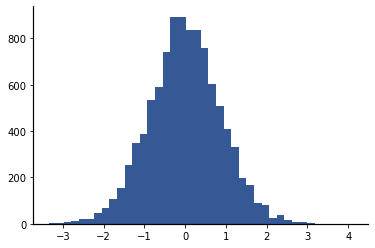

In [28]:
resample_mean_hist(pooled_covid, diff_urban, len(higher_urban), len(lower_urban))

A few obervations:
    
1. The difference of means has a bell shape -- we saw this shape before. Why do you think that is?
2. The majority of the values fall between -2 and +2. Thus, it is not surprising that getting a mean-difference as large as 2.34 is rare.

Later in the book, we will investigate how we can use the histogram to provide confidence intervals on the mean difference under the null hypothesis. This is a way to provide more information about how an observed difference in means compares to what is expected under the null hypothesis.

In [29]:
from jupytercards import display_flashcards

github='https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/main/03-first-data/flashcards/'
display_flashcards(github+'hypothesis-testing.json')